# TabNet for fastai

> This is an adaptation of TabNet (Attention-based network for tabular data) for fastai (>=2.0) library. The original paper https://arxiv.org/pdf/1908.07442.pdf. The implementation is taken from here https://github.com/dreamquark-ai/tabnet

## Install

`pip install fast_tabnet`

## How to use

`model = TabNetModel(emb_szs, n_cont, out_sz, embed_p=0., y_range=None, 
                     n_d=8, n_a=8,
                     n_steps=3, gamma=1.3, 
                     n_independent=2, n_shared=2, epsilon=1e-15,
                     virtual_batch_size=128, momentum=0.02)`

Parameters `emb_szs, n_cont, out_sz, embed_p, y_range` are the same as for fastai TabularModel.

- n_d : int
    Dimension of the prediction  layer (usually between 4 and 64)
- n_a : int
    Dimension of the attention  layer (usually between 4 and 64)
- n_steps: int
    Number of sucessive steps in the newtork (usually betwenn 3 and 10)
- gamma : float
    Float above 1, scaling factor for attention updates (usually betwenn 1.0 to 2.0)
- momentum : float
    Float value between 0 and 1 which will be used for momentum in all batch norm
- n_independent : int
    Number of independent GLU layer in each GLU block (default 2)
- n_shared : int
    Number of independent GLU layer in each GLU block (default 2)
- epsilon: float
    Avoid log(0), this should be kept very low


## Example

Below is an example from fastai library, but the model in use is TabNet

In [ ]:
from fastai2.basics import *
from fastai2.tabular.all import *
from fast_tabnet.core import *

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
df_main,df_test = df.iloc[:10000].copy(),df.iloc[10000:].copy()
df_main.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df_main))

In [ ]:
to = TabularPandas(df_main, procs, cat_names, cont_names, y_names="salary", splits=splits)

In [ ]:
dbch = to.dataloaders()
dbch.valid.show_batch()

,workclass,education,marital-status,occupation,relationship,race,age_na,fnlwgt_na,education-num_na,age,fnlwgt,education-num,salary
0,Local-gov,HS-grad,Married-civ-spouse,Craft-repair,Husband,Black,False,False,False,45.000000,556652.007499,9.0,>=50k
1,Private,Bachelors,Never-married,Sales,Not-in-family,White,False,False,False,29.000000,176683.000072,13.0,>=50k
2,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,False,False,False,29.000000,194939.999936,13.0,<50k
3,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,False,False,False,29.000000,52635.998841,9.0,<50k
4,State-gov,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,White,False,False,False,49.000000,122177.000557,10.0,>=50k
5,Private,12th,Married-civ-spouse,Machine-op-inspct,Other-relative,Other,False,False,False,28.000000,158737.000048,8.0,<50k
6,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,False,False,False,55.999999,192868.999992,9.0,>=50k
7,Self-emp-not-inc,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,False,False,False,56.999999,65080.002276,9.0,>=50k
8,Local-gov,Masters,Married-civ-spouse,Prof-specialty,Husband,White,False,False,True,50.000000,145165.999578,10.0,>=50k
9,Private,Assoc-voc,Never-married,Tech-support,Not-in-family,White,False,False,False,35.000000,186034.999925,11.0,<50k


In [ ]:
to_tst = to.new(df_test)
to_tst.process()
to_tst.all_cols.head()

,workclass,education,marital-status,occupation,relationship,race,age_na,fnlwgt_na,education-num_na,age,fnlwgt,education-num,salary
10000,5,10,3,2,1,2,1,1,1,0.456238,1.346622,1.164335,0
10001,5,12,3,15,1,4,1,1,1,-0.930752,1.259253,-0.419996,0
10002,5,2,1,9,2,5,1,1,1,1.040233,0.152193,-1.212162,0
10003,5,12,7,2,5,5,1,1,1,0.529237,-0.282632,-0.419996,0
10004,6,9,3,5,1,5,1,1,1,0.748235,1.449564,0.372169,1


In [ ]:
emb_szs = get_emb_sz(to); print(emb_szs)

[(10, 6), (17, 8), (8, 5), (16, 8), (7, 5), (6, 4), (2, 2), (2, 2), (3, 3)]


That's the use of the model

In [ ]:
model = TabNetModel(emb_szs, len(to.cont_names), 1, n_d=8, n_a=32, n_steps=1); 

In [ ]:
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dbch, model, MSELossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

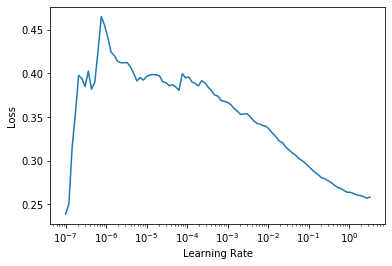

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.161420,0.163181,0.757500,00:04
1,0.140478,0.127033,0.757500,00:04
2,0.132842,0.117864,0.757500,00:04
3,0.126220,0.115803,0.757500,00:04
4,0.125338,0.117127,0.757500,00:03
5,0.123562,0.119050,0.757500,00:04
6,0.121530,0.117025,0.757500,00:04
7,0.116976,0.114524,0.757500,00:04
8,0.113542,0.114590,0.757500,00:04
9,0.111071,0.114707,0.757500,00:04


## Example with Bayesian Optimization

I like to tune hyperparameters for tabular models with Bayesian Optimization. You can optimize directly your metric using this approach if the metric is sensitive enough (in our example it is not and we use validation loss instead). Also, you should create the second validation set, because you will use the first as a training set for Bayesian Optimization. 


You may need to install the optimizer `pip install bayesian-optimization`

In [ ]:
from functools import lru_cache

In [ ]:
# The function we'll optimize
@lru_cache(1000)
def get_accuracy(n_d:Int, n_a:Int, n_steps:Int):
    model = TabNetModel(emb_szs, len(to.cont_names), 1, n_d=n_d, n_a=n_a, n_steps=n_steps);
    learn = Learner(dbch, model, MSELossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])
    learn.fit_one_cycle(5)
    return -float(learn.validate(dl=learn.dls.valid)[0])

This implementation of Bayesian Optimization doesn't work naturally with descreet values. That's why we use wrapper with `lru_cache`.

In [ ]:
def fit_accuracy(pow_n_d, pow_n_a, pow_n_steps):
    pow_n_d, pow_n_a, pow_n_steps = map(int, (pow_n_d, pow_n_a, pow_n_steps))
    return get_accuracy(2**pow_n_d, 2**pow_n_a, 2**pow_n_steps)

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'pow_n_d': (0, 8), 'pow_n_a': (0, 8), 'pow_n_steps': (0, 4)}

optimizer = BayesianOptimization(
    f=fit_accuracy,
    pbounds=pbounds,
)

In [ ]:
optimizer.maximize(
    init_points=15,
    n_iter=100,
)

|   iter    |  target   |  pow_n_a  |  pow_n_d  | pow_n_... |
-------------------------------------------------------------


epoch,train_loss,valid_loss,accuracy,time
0,1.376397,0.227991,0.757500,00:07
1,0.307311,0.188101,0.757500,00:06
2,0.192308,0.174029,0.757500,00:06
3,0.180625,0.168215,0.757500,00:07
4,0.171093,0.168311,0.757500,00:07


|  1        | -0.1683   |  2.099    |  2.108    |  2.532    |


epoch,train_loss,valid_loss,accuracy,time
0,0.156191,0.145624,0.757500,00:04
1,0.135885,0.131468,0.757500,00:04
2,0.124489,0.116068,0.757500,00:04
3,0.120778,0.115556,0.757500,00:04
4,0.118399,0.114798,0.757500,00:04


|  2        | -0.1148   |  5.582    |  0.5914   |  0.394    |


epoch,train_loss,valid_loss,accuracy,time
0,0.732101,0.201414,0.757500,00:09
1,0.213341,0.182902,0.757500,00:09
2,0.157790,0.154676,0.757500,00:09
3,0.143525,0.134003,0.757500,00:09
4,0.137171,0.128810,0.757500,00:09


|  3        | -0.1288   |  0.6418   |  3.424    |  3.649    |


epoch,train_loss,valid_loss,accuracy,time
0,0.255437,0.176615,0.757500,00:06
1,0.164086,0.158516,0.757500,00:07
2,0.149184,0.139764,0.757500,00:06
3,0.137243,0.126479,0.757500,00:06
4,0.132500,0.125504,0.757500,00:06


|  4        | -0.1255   |  6.121    |  1.372    |  2.897    |


epoch,train_loss,valid_loss,accuracy,time
0,0.834591,0.252279,0.757500,00:06
1,0.233243,0.190753,0.757500,00:06
2,0.174514,0.163240,0.757500,00:06
3,0.160865,0.149085,0.757500,00:06
4,0.153380,0.142670,0.757500,00:06


|  5        | -0.1427   |  7.183    |  5.46     |  2.131    |


epoch,train_loss,valid_loss,accuracy,time
0,0.280760,0.184326,0.757500,00:05
1,0.151150,0.149422,0.757500,00:05
2,0.136892,0.126405,0.757500,00:05
3,0.129048,0.124096,0.757500,00:05
4,0.129486,0.122428,0.757500,00:04


|  6        | -0.1224   |  0.5754   |  2.298    |  1.447    |


epoch,train_loss,valid_loss,accuracy,time
0,2.923816,0.290585,0.757500,00:09
1,0.635441,0.237105,0.757500,00:09
2,0.272063,0.170947,0.757500,00:09
3,0.179265,0.156215,0.757500,00:09
4,0.159060,0.151041,0.757500,00:09


|  7        | -0.151    |  6.365    |  7.881    |  3.652    |


epoch,train_loss,valid_loss,accuracy,time
0,1.436597,0.213113,0.757500,00:09
1,0.350264,0.189146,0.757500,00:09
2,0.187943,0.162571,0.757500,00:09
3,0.165730,0.154995,0.757500,00:09
4,0.155386,0.149732,0.757500,00:09


|  8        | -0.1497   |  5.544    |  5.838    |  3.925    |


epoch,train_loss,valid_loss,accuracy,time
0,0.430938,0.227863,0.757500,00:09
1,0.209979,0.177186,0.757500,00:09
2,0.179570,0.164046,0.757500,00:09
3,0.170003,0.161813,0.757500,00:09
4,0.168120,0.159528,0.757500,00:10


|  9        | -0.1595   |  4.231    |  1.842    |  3.959    |


epoch,train_loss,valid_loss,accuracy,time
0,0.196750,0.168031,0.757500,00:04
1,0.155173,0.152989,0.757500,00:04
2,0.144540,0.126592,0.757500,00:04
3,0.133649,0.126462,0.757500,00:04
4,0.124242,0.119457,0.757500,00:04


|  10       | -0.1195   |  7.513    |  6.718    |  0.3416   |


epoch,train_loss,valid_loss,accuracy,time
0,0.244845,0.162216,0.757500,00:04
1,0.152529,0.143890,0.757500,00:04
2,0.134093,0.119078,0.757500,00:04
3,0.123151,0.114896,0.757500,00:04
4,0.118943,0.114241,0.757500,00:04


|  11       | -0.1142   |  0.1011   |  7.301    |  0.3318   |


epoch,train_loss,valid_loss,accuracy,time
0,0.142999,0.161638,0.757500,00:04
1,0.133412,0.120533,0.757500,00:04
2,0.126682,0.119148,0.757500,00:04
3,0.124139,0.114975,0.757500,00:04
4,0.120500,0.115238,0.757500,00:04


|  12       | -0.1152   |  1.466    |  1.523    |  0.6053   |


epoch,train_loss,valid_loss,accuracy,time
0,1.292738,0.216998,0.757500,00:09
1,0.342039,0.196274,0.757500,00:09
2,0.207225,0.155081,0.757500,00:09
3,0.170700,0.151608,0.757500,00:09
4,0.156820,0.148455,0.757500,00:09


|  13       | -0.1485   |  3.104    |  6.879    |  3.043    |


epoch,train_loss,valid_loss,accuracy,time
0,0.248299,0.242661,0.757500,00:05
1,0.248616,0.242500,0.757500,00:05
2,0.247367,0.242500,0.757500,00:04
3,0.243612,0.242500,0.757500,00:05
4,0.248120,0.242500,0.757500,00:05


|  14       | -0.2425   |  6.56     |  0.3284   |  1.299    |


epoch,train_loss,valid_loss,accuracy,time
0,0.421470,0.166623,0.757500,00:09
1,0.186513,0.165642,0.757500,00:09
2,0.152764,0.137757,0.757500,00:09
3,0.142408,0.135240,0.757500,00:09
4,0.138158,0.131554,0.757500,00:09


|  15       | -0.1316   |  0.632    |  4.901    |  3.857    |


epoch,train_loss,valid_loss,accuracy,time
0,0.167871,0.171308,0.757500,00:03
1,0.142500,0.133382,0.757500,00:04
2,0.127953,0.120554,0.757500,00:04
3,0.122714,0.118568,0.757500,00:04
4,0.123305,0.116220,0.757500,00:04


|  16       | -0.1162   |  4.026    |  4.246    |  0.0      |


epoch,train_loss,valid_loss,accuracy,time
0,5.261782,0.234573,0.757500,00:16
1,0.748920,0.271949,0.757500,00:16


In [ ]:
optimizer.max